# Using modAL

This tutorial is based on the official documentation. For more information click [here](https://modal-python.readthedocs.io/en/latest/content/overview/modAL-in-a-nutshell.html) to get to the official website.

This tutorial is about introducing you to the concept of active learning through first steps with the *modAL* package.

Here you will learn to:
- write a simple active learning sampling strategy
- utilize the defined sampling strategy as part of the *modAL* package

**modAL** is an active learning framework for Python3, designed with modularity, flexibility and extensibility in mind. Built on top of scikit-learn, it allows you to rapidly create active learning workflows with nearly complete freedom. What is more, you can easily replace parts with your custom built solutions, allowing you to design novel algorithms with ease.

With the recent explosion of available data, you have can have millions of unlabelled examples with a high cost to obtain labels. For instance, when trying to predict the sentiment of tweets, obtaining a training set can require immense manual labour. But worry not, active learning comes to the rescue! In general, AL is a framework allowing you to increase classification performance by intelligently querying you to label the most informative instances.

## Installation

To install modAL you can use this command which will install the package directly from source:

`%pip install git+https://github.com/modAL-python/modAL.git`

(Remove `%` if you are running this command from your terminal or from a .py-file)

In [ ]:
%pip install git+https://github.com/modAL-python/modAL.git

## modAL in action

Active learning with a scikit-learn classifier, for instance RandomForestClassifier, can be as simple as the following.

```
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier

# initializing the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    X_training=X_training, y_training=y_training
)

# query for labels
query_idx, query_inst = learner.query(X_pool)

# ...obtaining new labels from the Oracle...

# supply label for queried instance
learner.teach(X_pool[query_idx], y_new)
```

### An example with active regression

To see modAL in real action, let’s consider an active regression problem with Gaussian processes! In this example, we shall try to learn a noisy sine function.

Let's define our dataset with the inputs `X` and the outputs `Y`

In [54]:
import numpy as np

np.random.seed(42)

# training data
x_training = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
ground_truth = lambda x: np.sin(x) + np.random.normal(scale=0.3, size=x.shape)
y_training = ground_truth(x_training)

# test data
x_test = np.linspace(0, 20, 1000)
y_test = ground_truth(x_test)

Let's see how our dataset looks like

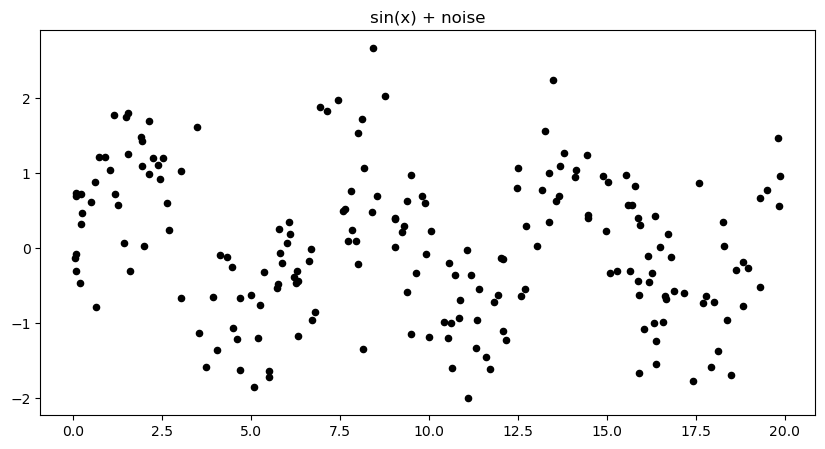

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.scatter(x_training, y_training, c='k', s=20)
plt.title('sin(x) + noise')
plt.show()

For active learning, we shall define a custom query strategy tailored to Gaussian processes. In a nutshell, a *query stategy* in modAL is a function taking (at least) two arguments (an estimator object and a pool of examples), outputting the index of the queried instance and the instance itself. In our case, the arguments are `regressor` and `X`.

In [56]:
def GP_regression_std(regressor, x, n_instances=1):
    _, std = regressor.predict(x, return_std=True)  # for a Gaussian process estimator, we get the standard deviation easily
    # get the n_instances indices with the highest standard deviation
    query_idx = np.argsort(std)[-n_instances:]    
    return query_idx, x[query_idx]

After setting up the query strategy and the data, the active learner can be initialized.

In [57]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

n_initial = 5  # initial amount of random samples

# get initial training data - random samples
initial_idx = np.random.choice(range(len(x_training)), size=n_initial, replace=False)  # draw random initial indices
x_training_init, y_training_init = x_training[initial_idx], y_training[initial_idx]  # set the initial training data

# define a kernel for the Gaussian process regressor
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# initialize the regressor and train it with the initial training data
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=x_training_init.reshape(-1, 1), y_training=y_training_init.reshape(-1, 1)
)

Let's check how well the estimator is fitted

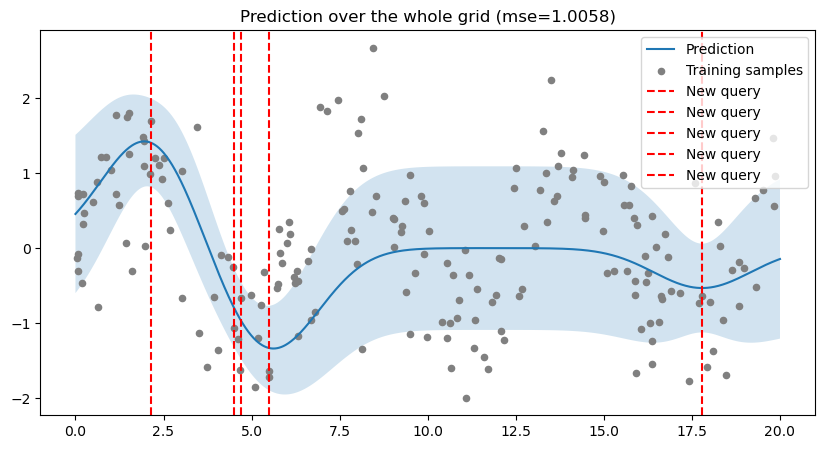

In [58]:
from sklearn.metrics import mean_squared_error

y_pred, y_std = regressor.predict(x_test.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

# compute the mean squared error
mse = mean_squared_error(y_test, y_pred)

# plotting method which we can reuse later
def plotting_method(x1, y1, y1_std, x_true=None, y_true=None, mse=None, x_new=None):
    plt.figure(figsize=(10, 5))
    plt.plot(x1, y1, label='Prediction')
    plt.fill_between(x1, y1 - y1_std, y1 + y1_std, alpha=0.2)
    if x_true is not None and y_true is not None:
        plt.scatter(x_true, y_true, c='grey', s=20, label='Training samples')
    if x_new is not None:
        # make a vertical line to indicate the new training sample
        if isinstance(x_new, (int, float)):
            x_new = [x_new]
        for x in x_new:
            plt.axvline(x=x, c='r', linestyle='--', label='New query')
    if mse is not None:
        plt.title(f'Prediction over the whole grid (mse={np.round(mse, 4)})')
    else:
        plt.title('Prediction')
    plt.legend()
    plt.show()

plotting_method(x_test, y_pred, y_std, x_true=x_training, y_true=y_training, mse=mse, x_new=x_training_init)

The blue band enveloping the regressor represents the standard deviation of the Gaussian process at the given point. 

Now we are ready to do active learning!

In [59]:
n_queries = 1

query_idx, query_instances = regressor.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
regressor.teach(x_training[query_idx].reshape(-1, 1), y_training[query_idx].reshape(-1, 1))  # fit the model with the query points

Let's check if the regressor benefited from the query

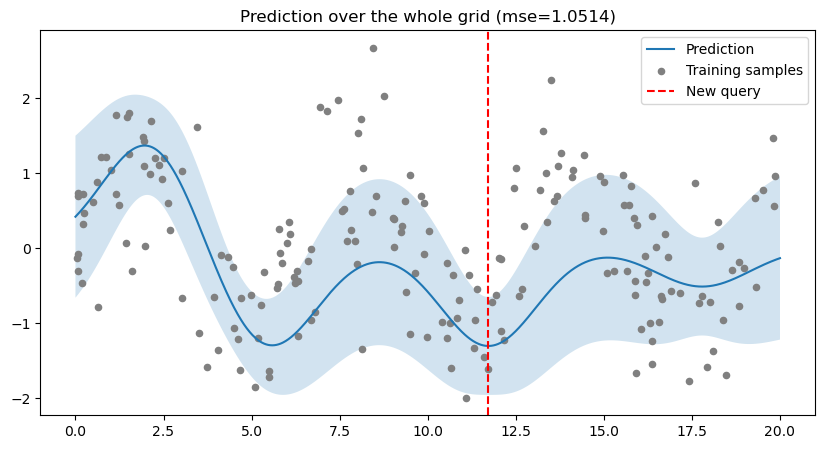

In [60]:
# get the predicted response and the standard deviation
y_pred, y_std = regressor.predict(x_test.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

# compute the mean squared error
mse = mean_squared_error(y_test, y_pred)

plotting_method(x_test, y_pred, y_std, x_true=x_training, y_true=y_training, mse=mse, x_new=x_training[query_idx])

Does it look already any better?

What happened from the initial plot to the second one?

Let's iterate a few more times and check the result after each iteration!

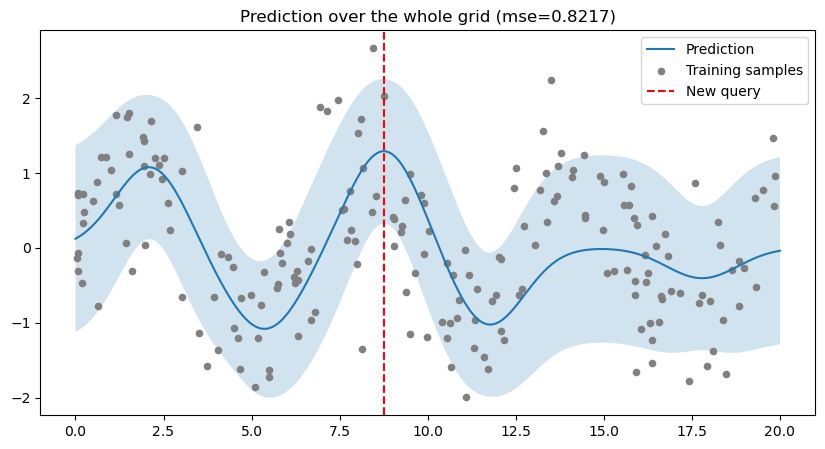

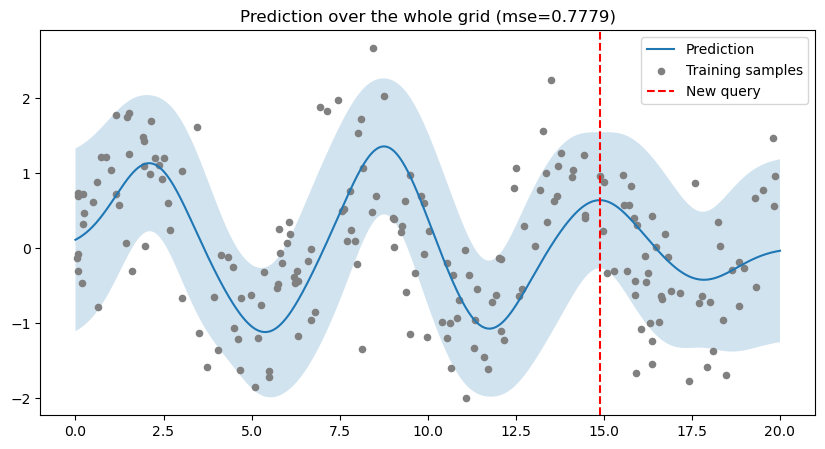

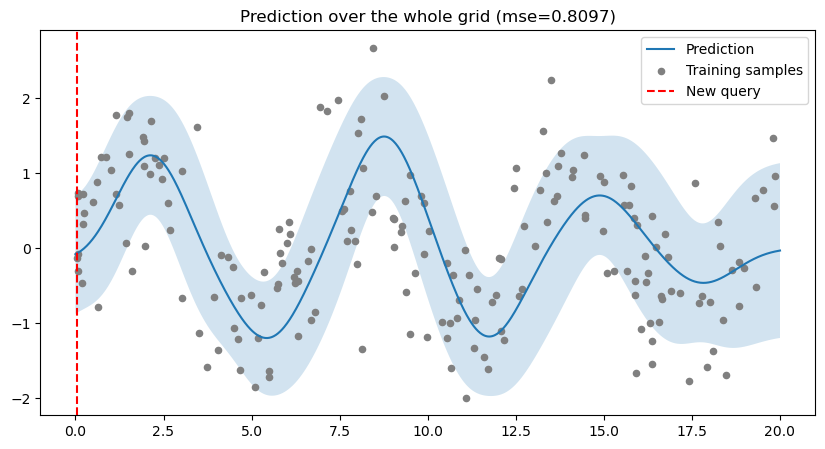

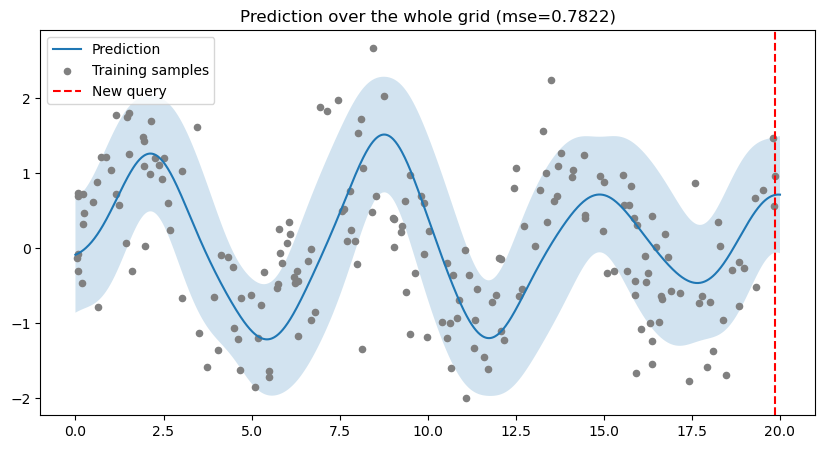

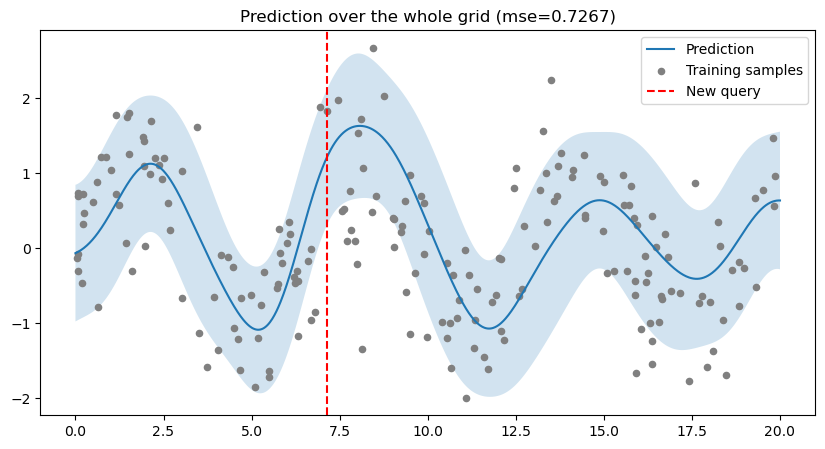

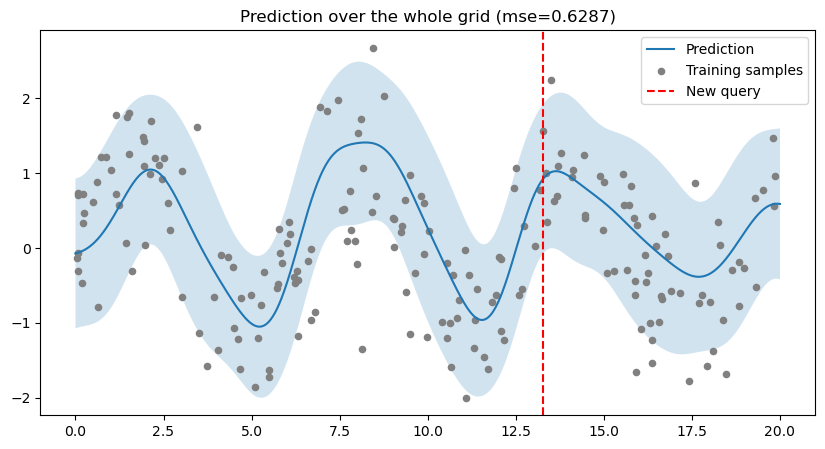

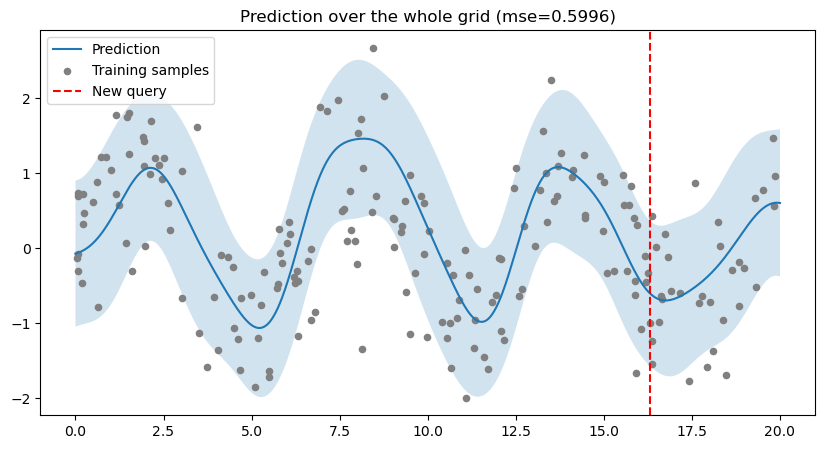

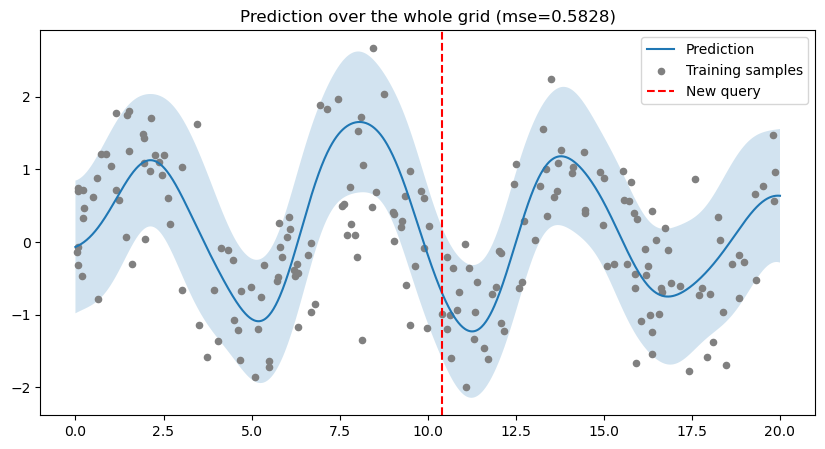

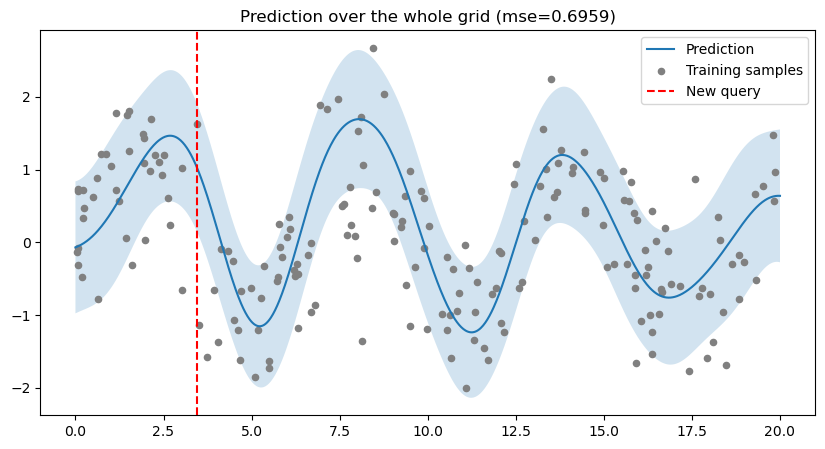

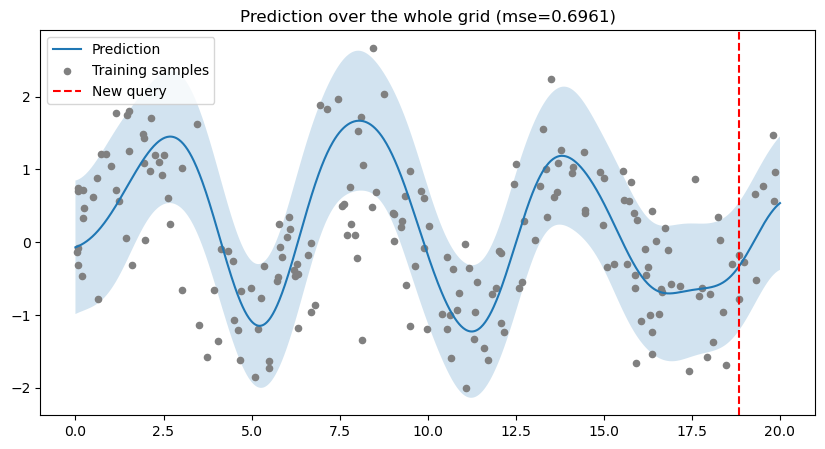

In [61]:
iterations = 10

for _ in range(iterations):
    query_idx, query_instance = regressor.query(x_training, n_instances=n_queries)  # get the query points from the regressor which are expected to be the most informative
    regressor.teach(x_training[query_idx].reshape(-1, 1), y_training[query_idx].reshape(-1, 1))  # fit the model with the query points
    
    # get the predicted response and the standard deviation
    y_pred, y_std = regressor.predict(x_test.reshape(-1, 1), return_std=True)
    # y_pred, y_std = y_pred.ravel(), y_std.ravel()

    # compute the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    plotting_method(x_test, y_pred, y_std, x_true=x_training, y_true=y_training, mse=mse, x_new=x_training[query_idx])

### Let's compare this with a random sampling method

Now we implement a simple random sampling method and give it directly the amount of training samples which we gave the active learning algorithm.

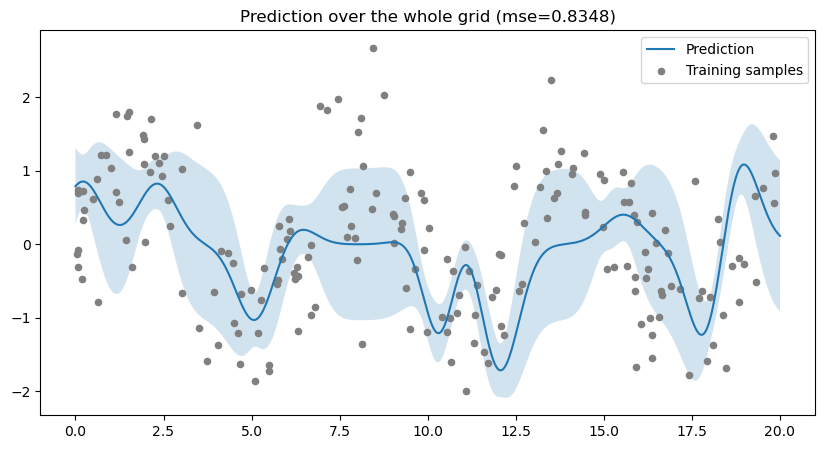

In [62]:
n_random_points = n_initial + (1+iterations)*n_queries

# get a training set of random points and evaluate the regression
idx = np.random.randint(0, len(x_training), size=n_random_points)
x_training_random = x_training[idx]
y_training_random = ground_truth(x_training_random)

regressor_rnd = GaussianProcessRegressor(kernel=kernel)  # initialize the same regressor as for the active learner
regressor_rnd.fit(x_training_random.reshape(-1, 1), y_training_random.reshape(-1, 1))  # fit the regressor to the random data
regressor_rnd_pred, regressor_rnd_std = regressor_rnd.predict(x_test.reshape(-1, 1), return_std=True)  # get the predicted response and the standard deviation
regressor_rnd_pred, regressor_rnd_std = regressor_rnd_pred.ravel(), regressor_rnd_std.ravel()

# compute the mean squared error
mse = mean_squared_error(y_test, regressor_rnd_pred)

plotting_method(x_test, regressor_rnd_pred, regressor_rnd_std, x_true=x_training, y_true=y_training, mse=mse)

How does the estimator with random sampling perform compared to active learning?

Can you explain the results by looking step-by-step at the chosen samples by the active learning algorithm?

Try and increase the noise bit-by-bit e.g., in steps of 0.2 and re-run the code.

What happens hereby?

## Congratulations!

You've finished the introductory tutorial to active learning and the key components of modAL!

Let's explore the key features of modAL even more in the next tutorial.